<a href="https://colab.research.google.com/github/eshal26/Convolutional-Neural-Networks/blob/main/custom_inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import os
import shutil
import sklearn
from sklearn.model_selection import train_test_split

<h2>Data Loading and Preprocessing</h2>

In [3]:
train_dir = 'train_dataset'
val_dir = 'validation_dataset'
test_dir = 'test_dataset'

# Define transformations for training, validation, and testing data
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.8245, 0.8547, 0.9387], std = [0.1323, 0.1431, 0.0530])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.8245, 0.8547, 0.9387], std = [0.1323, 0.1431, 0.0530])
])

# Create datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_test_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=val_test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

<h2>Defining Model</h2>

In [4]:
class InceptionModel(nn.Module):
    def __init__(self):
        super(InceptionModel, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # Convolution Layer 1
            nn.ReLU(),                                             # ReLU Activation
            nn.BatchNorm2d(16),                                  # Batch Normalization
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)    # Max Pooling
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # Convolution Layer 2
            nn.ReLU(),                                              # ReLU Activation
            nn.BatchNorm2d(32),                                   # Batch Normalization
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)     # Max Pooling
        )

        # Dropout Layers
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)

        # Flatten Layer
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(32 * 56 * 56, 2)  # Fully Connected Layer

        # Softmax for binary classification
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.dropout1(x)
        x = self.fc1(x)
        x = self.dropout2(x)
        x = self.softmax(x)
        return x

model = InceptionModel()
print(model)

SimpleInceptionModel(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout1): Dropout(p=0.3, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=100352, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)


<h2>Training Model</h2>

In [7]:
from collections import Counter
import numpy as np

all_labels = [label for _, label in train_dataset]
all_labels = np.array(all_labels)


unique_labels, counts = np.unique(all_labels, return_counts=True)
print(f"Unique Labels: {unique_labels}")
print(f"Counts: {counts}")

# Calculate class weights
num_samples = len(all_labels)
num_classes = len(unique_labels)
class_counts = Counter(all_labels)
class_weights = {class_id: num_samples / (num_classes * count) for class_id, count in class_counts.items()}
class_weights_tensor = torch.tensor([class_weights[i] for i in range(num_classes)], dtype=torch.float32)

print(f"Class Weights: {class_weights}")
print(f"Class Weights Tensor: {class_weights_tensor}")

Unique Labels: [0 1]
Counts: [ 403 2201]
Class Weights: {0: 3.230769230769231, 1: 0.5915492957746479}
Class Weights Tensor: tensor([3.2308, 0.5915])


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor.to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [10]:

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 30
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.7)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    # Step the scheduler
    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Training Loss: {epoch_loss:.4f}, "
          f"Training Accuracy: {train_accuracy:.2f}%, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Validation Accuracy: {val_accuracy:.2f}%")


Epoch 1/30, Training Loss: 0.5910, Training Accuracy: 68.28%, Validation Loss: 0.5117, Validation Accuracy: 79.08%
Epoch 2/30, Training Loss: 0.5682, Training Accuracy: 73.73%, Validation Loss: 0.4358, Validation Accuracy: 87.69%
Epoch 3/30, Training Loss: 0.5403, Training Accuracy: 76.73%, Validation Loss: 0.4238, Validation Accuracy: 89.23%
Epoch 4/30, Training Loss: 0.5328, Training Accuracy: 78.96%, Validation Loss: 0.4480, Validation Accuracy: 86.15%
Epoch 5/30, Training Loss: 0.5209, Training Accuracy: 73.04%, Validation Loss: 0.4962, Validation Accuracy: 81.85%
Epoch 6/30, Training Loss: 0.4817, Training Accuracy: 78.42%, Validation Loss: 0.5068, Validation Accuracy: 80.62%
Epoch 7/30, Training Loss: 0.4785, Training Accuracy: 79.95%, Validation Loss: 0.4527, Validation Accuracy: 86.15%
Epoch 8/30, Training Loss: 0.4732, Training Accuracy: 79.88%, Validation Loss: 0.4314, Validation Accuracy: 88.31%
Epoch 9/30, Training Loss: 0.4770, Training Accuracy: 78.69%, Validation Loss: 0

<h2>Plotting Accuracy and Loss</h2>

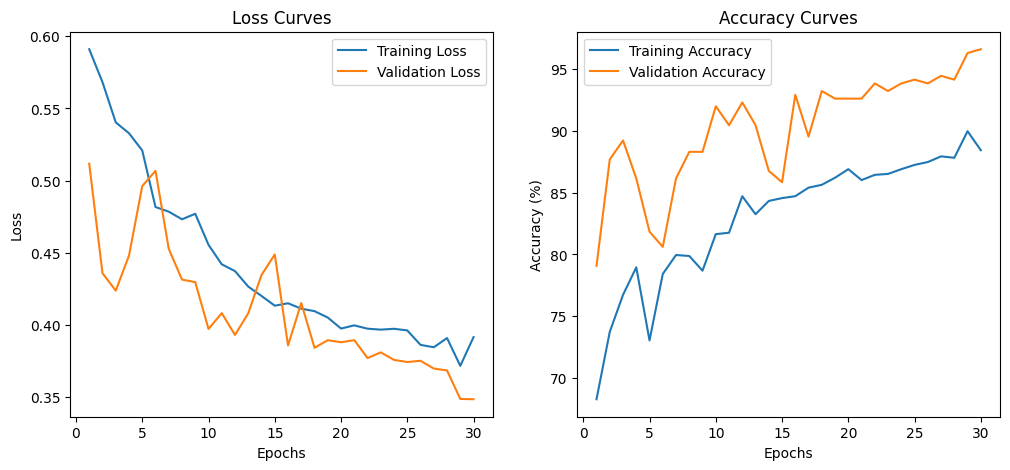

In [11]:

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plotting loss curves
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

# Plotting accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curves')
plt.legend()

plt.show()

<h2>Evaluating Model on Test Set</h2>

Test Loss: 0.3623
Test Accuracy: 0.9511
Test Precision: 0.9543
Test Recall: 0.9511
Test F1-score: 0.9522
Confusion Matrix:
 [[ 46   5]
 [ 11 265]]


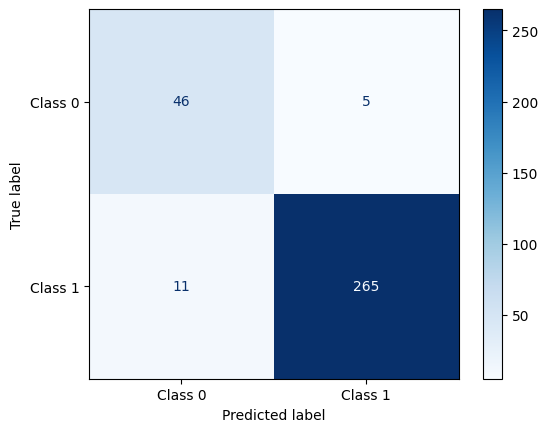

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.81      0.90      0.85        51
     Class 1       0.98      0.96      0.97       276

    accuracy                           0.95       327
   macro avg       0.89      0.93      0.91       327
weighted avg       0.95      0.95      0.95       327



In [19]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    test_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Get the predicted labels
            _, preds = torch.max(outputs, 1)

            # Convert predictions and labels to numpy for metrics calculation
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

            # Compute loss
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

    # Compute average test loss
    test_loss /= len(dataloader.dataset)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test Precision: {precision:.4f}')
    print(f'Test Recall: {recall:.4f}')
    print(f'Test F1-score: {f1:.4f}')

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:\n", cm)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    # Print classification report
    class_report = classification_report(all_labels, all_preds, target_names=['Class 0', 'Class 1'])
    print("Classification Report:\n", class_report)

    return test_loss, accuracy, precision, recall, f1, cm, class_report

test_loss, test_accuracy, test_precision, test_recall, test_f1, cm, class_report = evaluate_model(model, test_loader, criterion, device)


<h2>Saving Trained Model</h2>

In [20]:

model_path = '/content/drive/My Drive/custom_inception.pth'
torch.save(model, model_path)
